# Techniques of High Performance Computing - Assignment 2

### Name: John Duffy

### Student Number: 19154676

# IMPORTANT NOTE


In [1]:
# Import libraries common to Questions 1 & 2.

import numpy as np
import pyopencl as cl

from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import LinearOperator, cg

# Question 1

## OpenCL CSR Matrix-Vector Product

**IMPORTANT NOTE**

My MacBook Pro is equipped with an Intel Core i5 CPU and an Intel Iris Plus Graphics GPU as depicted below.

    cl.get_platforms()[0].get_devices()

    [<pyopencl.Device 'Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz' on 'Apple' at 0xffffffff>,
     <pyopencl.Device 'Intel(R) Iris(TM) Plus Graphics 655' on 'Apple' at 0x1024500>]
     
To ensure a context is created using the CPU for Question 1 (so that AVX2 technology is available) the function cl.Context() is used as below.

    ctx = cl.Context(dev_type = cl.device_type.CPU)  # Tell OpenCL to use the CPU device.
    
The function cl.get_some_context() used in the course lecture notes is not specific enough (on my MacBook Pro at least) which then causes kernel build problems. This seems to be specific to macOS 10.14 Mojave.

### Program Description

This program...


### Optimisation Results

A class LinearOperatorBaseline was created to use as a baseline for measuring the performance gains through subsequnt use of OpenCL and AVX2.

In [186]:
# Define the class LinearOperatorBaseline for baseline performance measurements.

class LinearOperatorBaseline(LinearOperator):
    """
    This class... 
    """
    
    def __init__(self, m, n, data, indices, indptr):
        """
        """
        self.shape = (m, n)

        self.data = data
        self.indices = indices
        self.indptr = indptr
    
    def _matvec(self, v):
        """
        """
        y = np.zeros(self.shape[1], dtype=np.float64)
        
        for i in range(self.shape[1]): 
            y[i] = np.dot(self.data[self.indptr[i]:self.indptr[i + 1]], v[self.indices[self.indptr[i]]:self.indptr[i + 1]])
            
        return y

In [187]:
# Create a test instance of LinearOperatorBaseline.

M = 10000
N = 10000

csr = eye((N), dtype=np.float64).tocsr()

linear_operator = LinearOperatorBaseline(M, N, csr.data, csr.indices, csr.indptr)

In [188]:
# Test the instance.

v = np.full((N), 2, dtype=np.float64)

linear_operator.matvec(v)

array([2., 2., 2., ..., 2., 2., 2.])

In [189]:
%%timeit

linear_operator.matvec(v)

20.2 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [190]:
%%timeit

linear_operator * v

20.4 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [191]:
# Define the class LinearOperatorOpenCL.

class LinearOperatorOpenCL(LinearOperator):
    """
    This class... 
        """
    
    def __init__(self, m, n, data, indices, indptr):
        """
        This function...
        """
        
        self.shape = (m, n)
        
        self.ctx = cl.Context(dev_type = cl.device_type.CPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
        
        mf = cl.mem_flags
        
        self.device_data = cl.Buffer(self.ctx, \
                                     mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                     hostbuf = data)
    
        self.device_indices = cl.Buffer(self.ctx, \
                                        mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                        hostbuf = indices)
        
        self.device_indptr = cl.Buffer(self.ctx, \
                                       mf.READ_ONLY | mf.COPY_HOST_PTR, \
                                       hostbuf = indptr)
        
        self.device_u = cl.Buffer(self.ctx, \
                                  mf.READ_ONLY, \
                                  size = self.shape[1] * np.dtype(np.float64).itemsize)
        
        self.device_v = cl.Buffer(self.ctx, \
                                  mf.WRITE_ONLY, \
                                  size = self.shape[1] * np.dtype(np.float64).itemsize)

        self.program = cl.Program(self.ctx, """
        __kernel void matvec_opencl(
            const int m,
            const int n,
            __global const double *data,
            __global const int *indices,
            __global const int *indptr,
            __global const double *u,
            __global double *v
        )
        {
            int row_id = get_global_id(0);
           
            double acc = 0.0;
            
            for (int i = indptr[row_id]; i < indptr[row_id + 1]; i++) {
                acc += data[i] * u[indices[i]];
            }

            v[row_id] = acc; 
        }
        """).build()

    
    def _matvec(self, u):
        """
        """

        cl.enqueue_copy(self.queue, self.device_u, u)

        self.program.matvec_opencl(self.queue, \
                                   (self.shape[0], self.shape[1]), \
                                   (1, 1), \
                                   np.int32(self.shape[0]), \
                                   np.int32(self.shape[1]), \
                                   self.device_data, \
                                   self.device_indices, \
                                   self.device_indptr, \
                                   self.device_u, \
                                   self.device_v \
                                  )

        v = np.zeros((self.shape[0]), dtype=np.float64)

        cl.enqueue_copy(self.queue, v, self.device_v)
            
        return v

In [192]:
# Create a test instance of LinearOperatorOpenCL.

M = 10000
N = 10000

csr = eye((M), dtype=np.float64).tocsr()

linear_operator = LinearOperatorOpenCL(M, N, csr.data, csr.indices, csr.indptr)

In [193]:
# Test the instance.

v = np.full((N), 2, dtype=np.float64)

linear_operator.matvec(v)

array([2., 2., 2., ..., 2., 2., 2.])

In [194]:
%%timeit

linear_operator.matvec(v)

84.8 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [195]:
%%timeit

linear_operator * v

85.1 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Question 2

## Solving a Poisson Problem with OpenCL

**IMPORTANT NOTE**

My MacBook Pro is equipped with an Intel Core i5 CPU and an Intel Iris Plus Graphics GPU as depicted below.

    cl.get_platforms()[0].get_devices()

    [<pyopencl.Device 'Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz' on 'Apple' at 0xffffffff>,
     <pyopencl.Device 'Intel(R) Iris(TM) Plus Graphics 655' on 'Apple' at 0x1024500>]
     
To ensure a context is created using the GPU for Question 2 the function cl.Context() is used as below.

    ctx = cl.Context(dev_type = cl.device_type.GPU)  # Tell OpenCL to use the GPU device.
    
The function cl.get_some_context() used in the course lecture notes is not specific enough (on my MacBook Pro at least) which then causes kernel build problems. This seems to be specific to macOS 10.14 Mojave.

### Program Description

This program...

In [15]:
# Define the class StencilOperatorOpenCL.

class StencilOperatorOpenCL(LinearOperator):
    """
    This class... 
    """
    
    def __init__(self, m):
        """
        This function...
        """
        
        self.m = m
        
        self.shape = (m * m, m * m)
        
        self.ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
        
        mf = cl.mem_flags
        
        self.device_u = cl.Buffer(self.ctx, mf.READ_ONLY, size = self.shape[0] * np.dtype(np.float32).itemsize)
        self.device_v = cl.Buffer(self.ctx, mf.WRITE_ONLY, size = self.shape[0] * np.dtype(np.float32).itemsize)

        self.program = cl.Program(self.ctx, """
        __kernel void stencil_kernel(
            __global const double *u,
            __global double *v
        )
        {
            //int i = get_global_id(0);
            
            //v[i] = 0.5 * u[i];

            int i = get_global_id(0);
            int j = get_global_id(1);
 
            int m = 32;
 
            if (i == 0 || i == (m - 1) || j == 0 || j == (m - 1)) {
                v[i * m + j] = u[i * m + j];
                return;
            }            
 
            v[i * m + j] = 4 * u[i * m + j] - u[i * m + j - 1] - u[i * m + j + 1] - u[(i - 1) * m + j] - u[(i + 1) * m + j];
            
            //v[i * m + j] = u[i * m + j];
        }
        """).build()

    
    def _matvec(self, u):
        """
        """
        
        self.dtype = u.dtype
        
        cl.enqueue_copy(self.queue, self.device_u, u)

        self.program.stencil_kernel(self.queue, \
                                    (32, 32), \
                                    (1, 1), \
                                    self.device_u, \
                                    self.device_v)

        v = np.zeros((self.shape[0]), dtype=np.float32)

        cl.enqueue_copy(self.queue, v, self.device_v)
            
        return v

In [16]:
# Create an instance of StencilOperatorOpenCL.

M = 32

stencil = StencilOperatorOpenCL(M)

In [17]:
# Test the instance.

u = np.full((M * M), 4, dtype=np.float32)

stencil.matvec(u)

array([4., 4., 4., ..., 4., 4., 4.], dtype=float32)

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot(x, y, data):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    X = range(x)
    Y = range(y)
    X, Y = np.meshgrid(X, Y)
    #R = np.sqrt(X**2 + Y**2)
    Z = data[X, Y]

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()



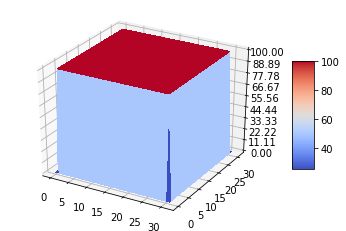

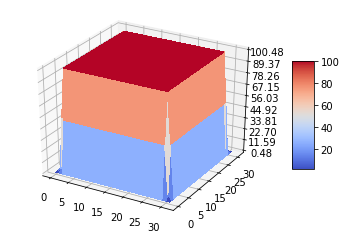

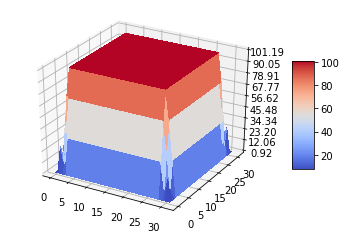

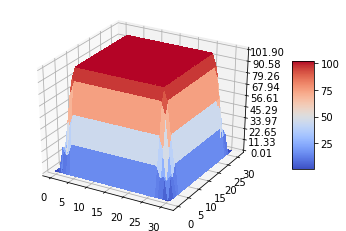

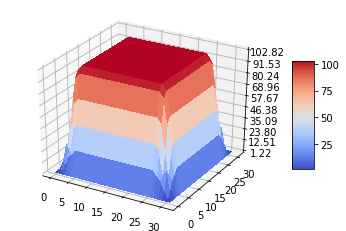

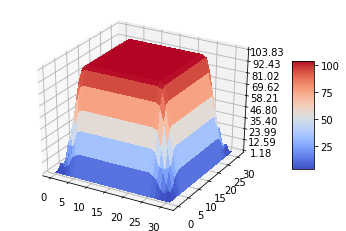

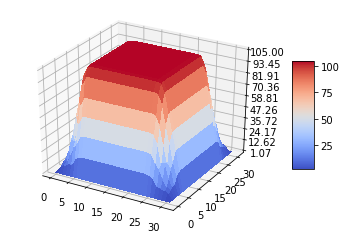

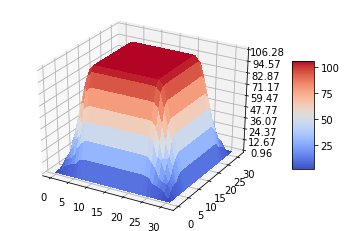

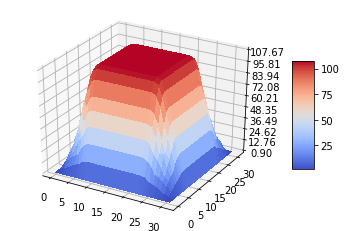

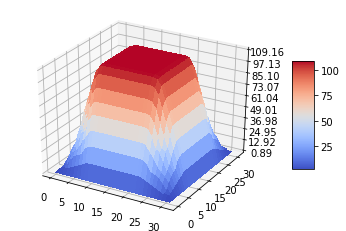

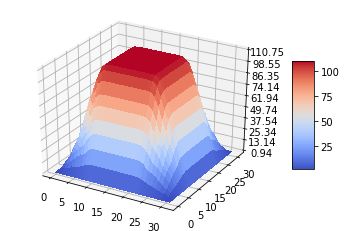

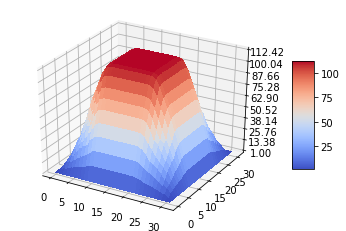

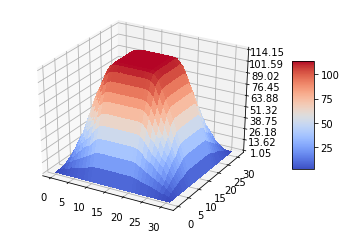

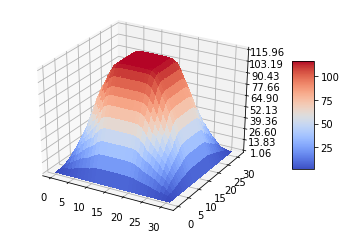

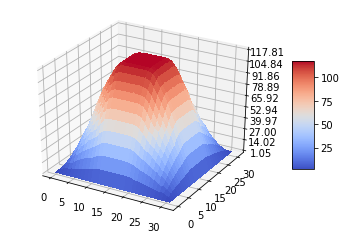

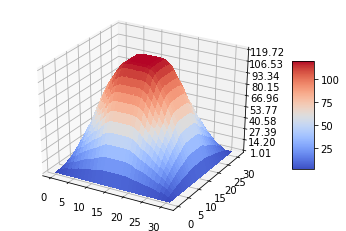

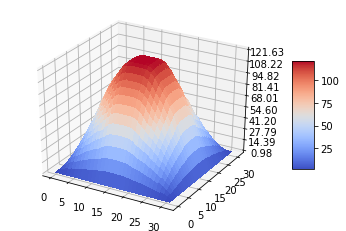

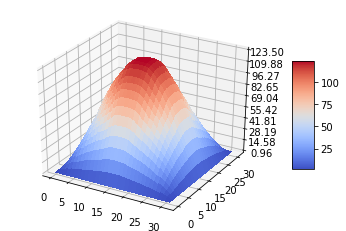

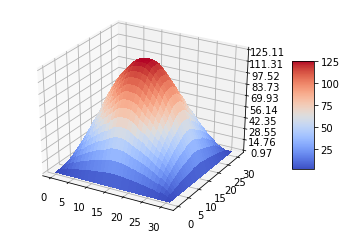

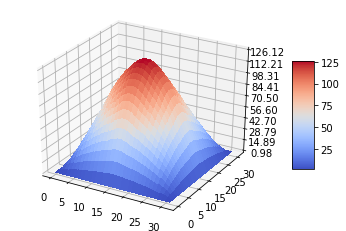

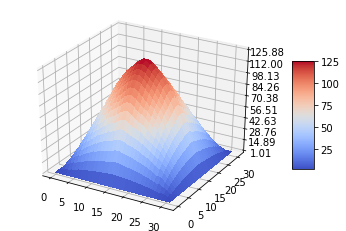

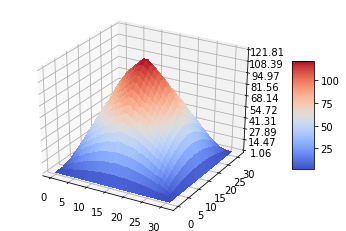

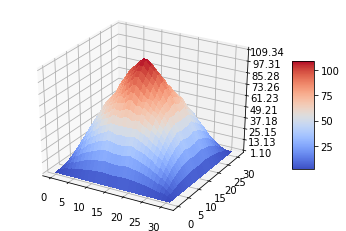

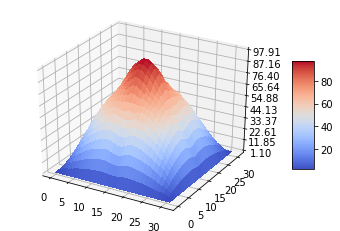

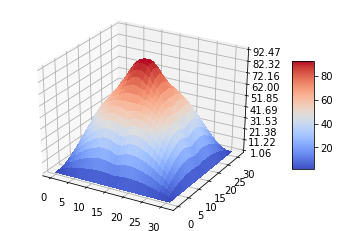

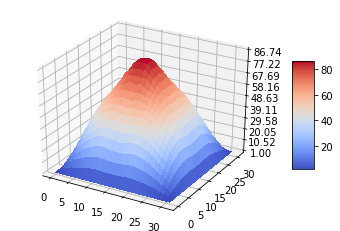

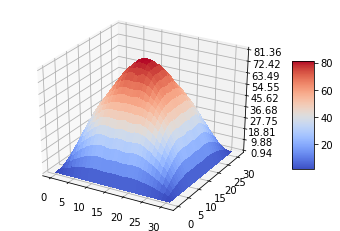

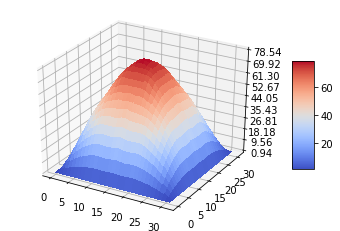

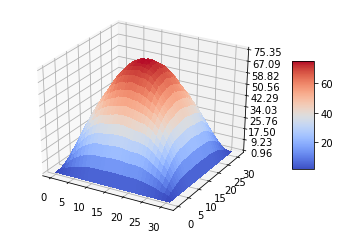

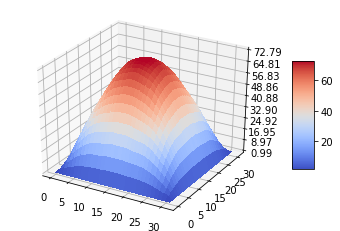

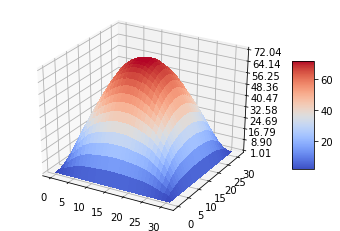

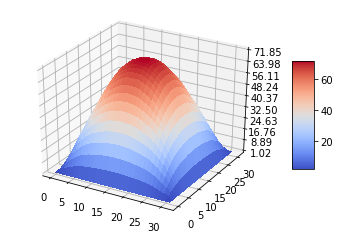

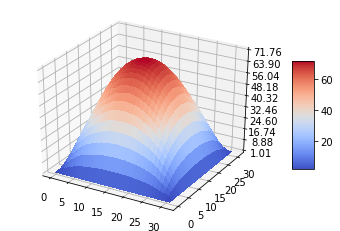

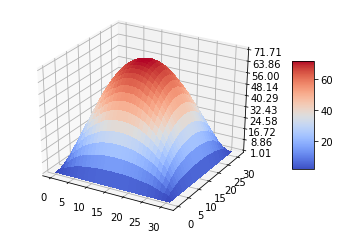

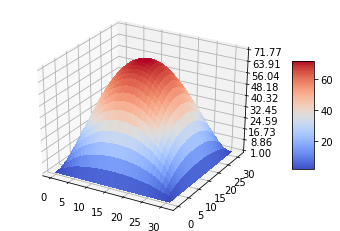

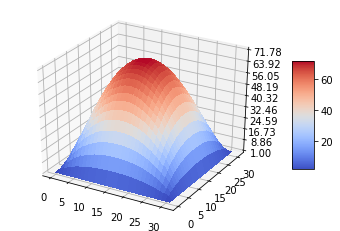

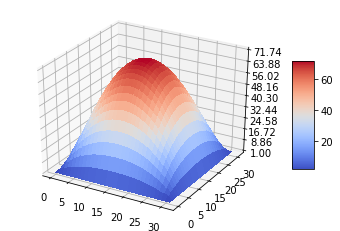

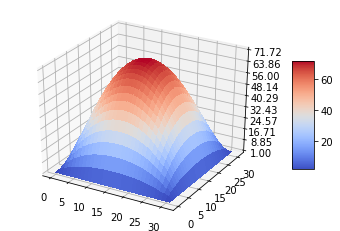

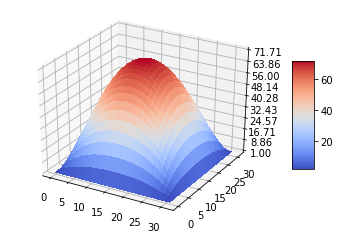

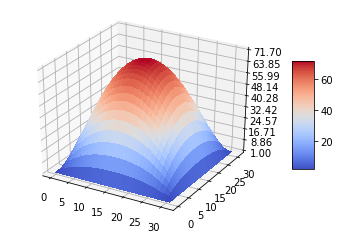

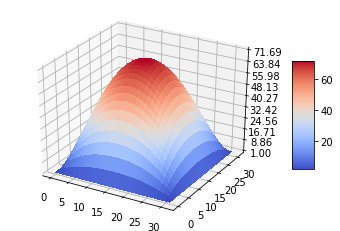

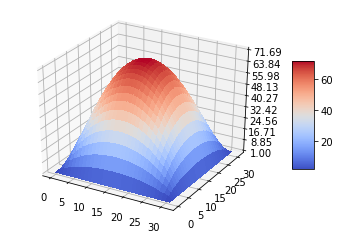

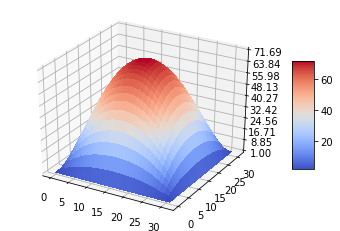

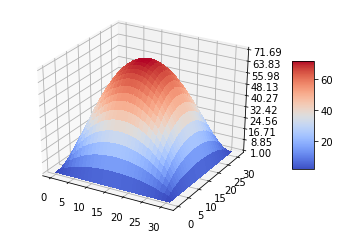

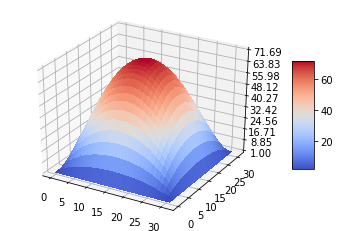

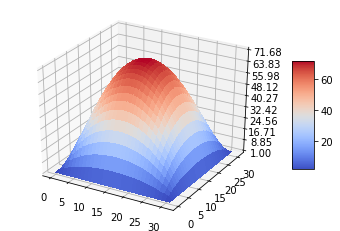

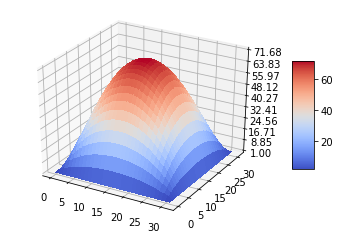

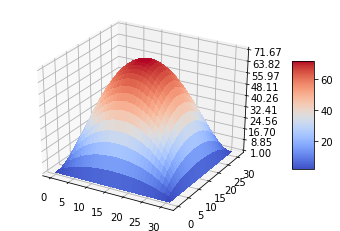

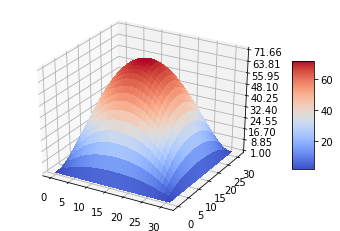

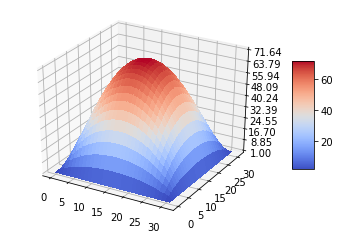

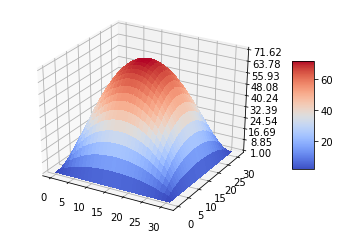

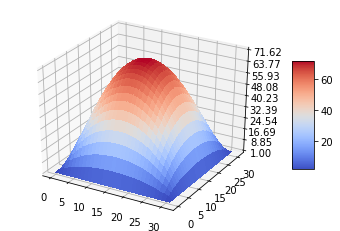

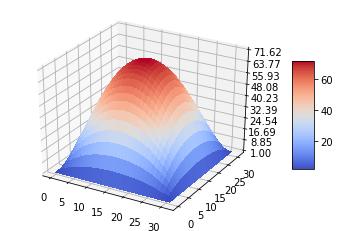

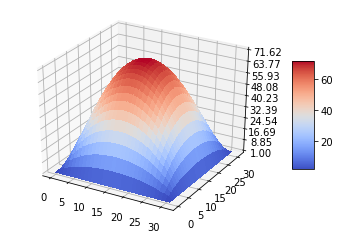

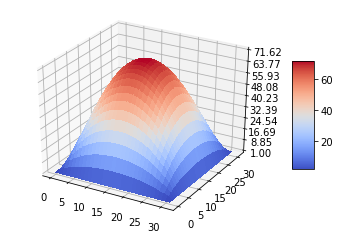

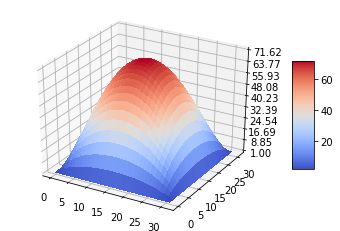

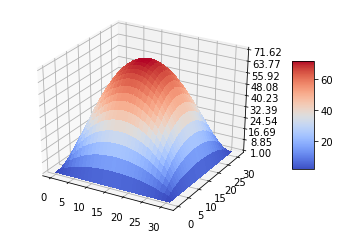

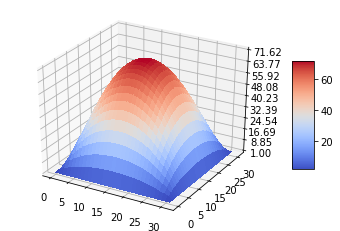

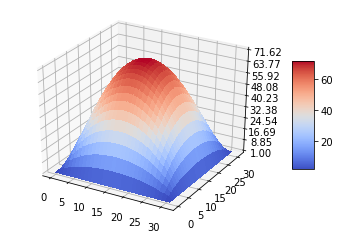

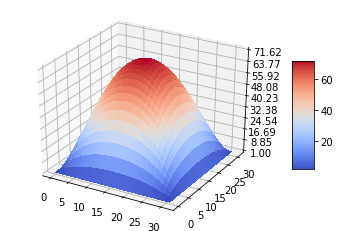

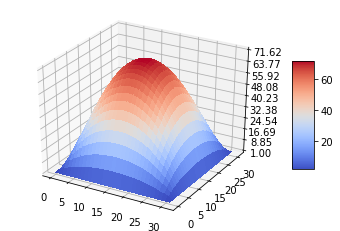

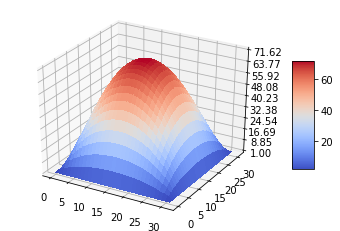

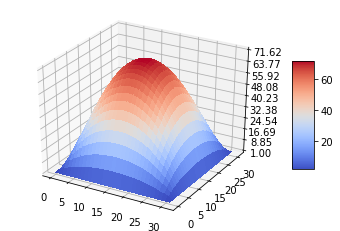

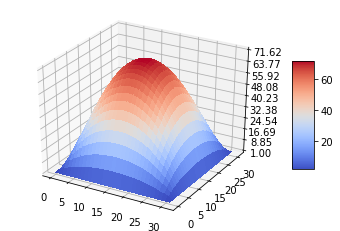

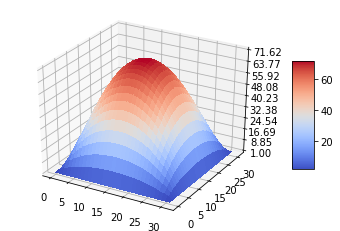

In [19]:
# Use Conjugate Iteration.

M = 32

u = np.full((M, M), 100, dtype=np.float32)

#u = np.array([[0,0,0,0],[0,1,1,0],[0,1,1,0],[0,0,0,0]], dtype=np.float32).flatten()

b = np.ones((M * M), dtype=np.float32)

u[0, :] = 0
u[:, 0] = 0

u[M - 1, :] = 0
u[:, M - 1] = 0

plot(M, M, u)

iterations = []

#import matplotlib.pyplot as plt

def cg_callback(xk):
    #plt.imshow(xk.reshape(M, M))
    #plt.show()
    #iterations.append(xk.reshape(M, M))
    
    data = xk.reshape(M, M)
    plot(M, M, data)

    
    
solution, info = cg(StencilOperatorOpenCL(M), b, x0 = u.flatten(), maxiter = 64, callback = cg_callback)

In [20]:
solution.reshape(M, M)

array([[0.9999995, 0.9999995, 0.9999995, ..., 0.9999995, 0.9999995,
        0.9999995],
       [0.9999995, 3.0039024, 4.5077977, ..., 4.5077934, 3.003897 ,
        0.9999995],
       [0.9999995, 4.507802 , 7.317951 , ..., 7.3179445, 4.5077963,
        0.9999995],
       ...,
       [0.9999995, 4.5077915, 7.3179326, ..., 7.3179493, 4.507798 ,
        0.9999995],
       [0.9999995, 3.0038958, 4.5077868, ..., 4.507795 , 3.003896 ,
        0.9999995],
       [0.9999995, 0.9999995, 0.9999995, ..., 0.9999995, 0.9999995,
        0.9999995]], dtype=float32)